# Hybrid Recommdation System

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [42]:
#读取初始数据
user_act = pd.read_csv('./data/log.csv')
product = pd.read_csv('./data/product.csv',encoding='gbk')
user_act.to_excel('./data/log.xlsx')
product.to_excel('./data/product.xlsx')

PermissionError: [Errno 13] Permission denied: './data/product.xlsx'

### 用户行为数据预处理

In [ ]:
#处理用户行为数据保证有200个用户、item_id不超过562
user_act = pd.read_excel('./data/log.xlsx')
np.random.seed(42)

# 生成符合正态分布的 user_id 和 item_id 数据
# 用户ID在1到200之间，均值100，标准差25
user_id_normal = np.random.normal(loc=100, scale=25, size=len(user_act))
user_id_normal = np.clip(user_id_normal, 1, 200).astype(int)  # 确保在1到200之间

# 商品ID在1到562之间，均值281，标准差150
item_id_normal = np.random.normal(loc=281, scale=150, size=len(user_act))
item_id_normal = np.clip(item_id_normal, 1, 562).astype(int)  # 确保在1到562之间

# 将生成的数据替换原始数据中的user_id和item_id列
user_act['user_id'] = user_id_normal
user_act['item_id'] = item_id_normal

In [8]:
# 保存修改后的数据为新的Excel文件
user_act.to_excel('./data/processed_log.xlsx', index=False)

In [74]:
user_act = pd.read_excel('./data/processed_log.xlsx')

In [75]:
# 计算每个 item_id 的出现次数
popular_products = user_act.groupby('item_id').size().reset_index(name='count')

# 按照出现次数 'count' 降序排序
most_popular = popular_products.sort_values('count', ascending=False)

most_popular.head(10)

most_popular.to_excel('./data/most_popular.xlsx')

In [ ]:
#合并 'popular_products' 和 'user_act'，以便将出现次数添加到每个 item_id 上
user_item_counts = pd.merge(user_act,popular_products,on='item_id',how='left')
user_item_counts.head()
user_item_counts.to_excel('./data/user_item_counts.xlsx')

<Axes: >

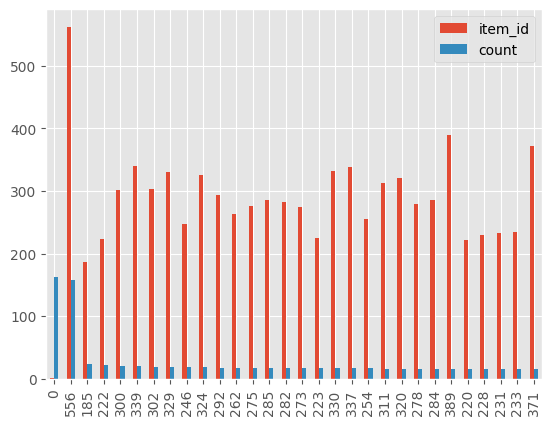

In [15]:
most_popular.head(30).plot(kind = "bar")

## 构造用户-商品购买矩阵

In [45]:
user_item_counts = pd.read_excel('./data/user_item_counts.xlsx')
user_item_counts.head()

,item_id,user_id,action,vtime,count
0,126,18,buy,2014/9/24 12:28,8
1,223,20,buy,2014/9/22 11:06,22
2,414,20,buy,2014/9/21 17:29,9
3,202,24,buy,2014/9/11 15:46,6
4,341,24,buy,2014/9/19 10:18,12


In [46]:
purchase_matrix = user_item_counts.pivot_table(values='count',index='user_id',columns='item_id',fill_value=0)
purchase_matrix.to_excel('./data/purchase_matrix.xlsx')

In [47]:
purchase_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,551,552,553,555,556,557,558,560,561,562
user_id,,,,,,,,,,,,,,,,,,,,,
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 数据加载与预处理

## 用户冷启动/未登录：对商品受欢迎度排序

In [18]:
#加载商品受欢迎度列表
most_popular = pd.read_excel('./data/most_popular.xlsx')

# 基于商品受欢迎度的推荐函数
def popularity_based_recommend(n_recommend=10):
    """
    基于商品受欢迎度的推荐函数
    参数：
        n_recommend: 推荐的商品数量
    返回：
        推荐商品列表
    """
    # 获取最受欢迎的商品列表
    popular_items = most_popular['item_id'].tolist()
    
    # 返回前N个推荐商品
    return popular_items[:n_recommend]

# 示例使用
print("基于受欢迎度的推荐商品：")
print(popularity_based_recommend(10))


基于受欢迎度的推荐商品：
[1, 562, 186, 223, 301, 340, 303, 330, 247, 325]


In [19]:
# 加载用户-商品购买矩阵
purchase_matrix = pd.read_excel('./data/purchase_matrix.xlsx', index_col='user_id')
print("Purchase Matrix Shape:", purchase_matrix.shape)
purchase_matrix.head()

Purchase Matrix Shape: (157, 557)


,1,2,3,4,5,6,7,8,9,10,...,551,552,553,555,556,557,558,560,561,562
user_id,,,,,,,,,,,,,,,,,,,,,
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# 加载商品描述数据
product = pd.read_excel('./data/product.xlsx')
product_descriptions = product[['item_id','title']].copy()
product_descriptions.head()

,item_id,title
0,1,2014 秋冬款 绵羊皮皮衣 特价 男士皮衣 立领 修身 短款 真皮夹克 外套
1,2,优 凡 秋冬新款 男装 棉 直筒休闲长裤 小脚 裤子 男士 韩版 修身休闲裤 男
2,3,2014 春秋 海宁 新款 修身皮夹克 绵羊皮 立领 潮 短款 男士皮衣 真皮皮衣 男
3,4,2014 新款 秋冬 外 穿 仿皮 打底裤 小脚裤 韩版 显 瘦 皮裤 女 紧身 长裤 潮 大码
4,5,韩国代购 2014 秋装 显 瘦 高腰牛仔裤 女 小脚裤 铅笔裤 弹力 紧身 长裤 潮


## 基于协同过滤的推荐
使用奇异值分解（SVD）对购买矩阵进行降维，并计算商品之间的相似度以进行推荐。


In [21]:
def collaborative_filtering_recommend(item_id, purchase_matrix, n_recommend=10):
    """
    基于商品的协同过滤
    """
    # 奇异值分解
    SVD = TruncatedSVD(n_components=10, random_state=42)
    decomposed_matrix = SVD.fit_transform(purchase_matrix.T)  # 按商品分解
    
    # 计算商品之间的余弦相似度
    similarity_matrix = cosine_similarity(decomposed_matrix)
    
    # 获取商品名称列表
    product_names = list(purchase_matrix.columns)
    
    try:
        product_idx = product_names.index(item_id)
    except ValueError:
        print(f"商品ID {item_id} 不存在于购买矩阵中。")
        return []
    
    # 获取相似度分数
    similarity_scores = similarity_matrix[product_idx]
    
    # 按相似度从高到低排序
    similar_indices = similarity_scores.argsort()[::-1]
    
    # 获取推荐商品
    recommended_items = [product_names[i] for i in similar_indices if product_names[i] != item_id]
    
    return recommended_items[:n_recommend]


In [22]:
def collaborative_filtering_recommend_user_based(user_id, purchase_matrix, n_recommend=10):
    """
    基于用户的协同过滤推荐
    参数：
        user_id: 目标用户ID
        purchase_matrix: 用户-商品购买矩阵
        n_recommend: 推荐的商品数量
    返回：
        推荐商品列表
    """
     # 检查用户是否在购买矩阵中有历史行为
    if user_id not in purchase_matrix.index:
        print(f"用户 {user_id} 没有历史购买记录，使用基于受欢迎度的推荐。")
        return popularity_based_recommend(n_recommend=n_recommend)  # 如果没有购买记录，基于受欢迎度推荐
    
    # 计算用户之间的相似度
    similarity_matrix = cosine_similarity(purchase_matrix)
    
    # 获取目标用户的索引
    user_idx = purchase_matrix.index.get_loc(user_id)
    
    # 获取该用户与所有其他用户的相似度
    user_similarity = similarity_matrix[user_idx]
    
    # 按照相似度排序，选择相似度最高的用户
    similar_users_idx = user_similarity.argsort()[::-1]
    
    # 推荐商品：选择与最相似的用户共同购买的商品（去重）
    recommended_items = set()
    for similar_user_idx in similar_users_idx[1:]:
        similar_user_id = purchase_matrix.index[similar_user_idx]
        purchased_items = purchase_matrix.loc[similar_user_id][purchase_matrix.loc[similar_user_id] > 0].index
        recommended_items.update(purchased_items)
        
        if len(recommended_items) >= n_recommend:
            break
    
    return list(recommended_items)[:n_recommend]


## 基于内容的推荐
利用商品的标题信息，通过TF-IDF向量化和余弦相似度计算，为用户推荐相似商品。


In [23]:
def content_based_recommend(item_id, product, vectorizer, svd_model, n_recommend=10):
    """
    基于内容的推荐函数
    """
    # 获取目标商品的标题
    try:
        product_title = product[product['item_id'] == item_id]['title'].values[0]
    except IndexError:
        print(f"商品ID {item_id} 不存在于商品描述中。")
        return []
    
    # 向量化目标商品的标题
    Y = vectorizer.transform([product_title])
    
    # 降维
    Y_reduced = svd_model.transform(Y)
    
    # 计算相似度
    similarity = cosine_similarity(Y_reduced, svd_model.transform(vectorizer.transform(product['title'])))
    similarity_scores = similarity.flatten()
    
    # 按相似度排序
    similar_indices = similarity_scores.argsort()[::-1]
    
    # 获取推荐商品
    recommended_items = [product['item_id'].iloc[i] for i in similar_indices if product['item_id'].iloc[i] != item_id]
    
    return recommended_items[:n_recommend]


## 基于K-means聚类的推荐
通过对商品描述进行聚类，为用户推荐同一簇内的其他商品。


In [24]:
def clustering_recommend(item_id, product, kmeans_model, n_recommend=10):
    """
    基于K-means聚类的推荐函数
    """
    # 查找商品所属的簇
    try:
        product_index = product[product['item_id'] == item_id].index[0]
    except IndexError:
        print(f"商品ID {item_id} 不存在于商品描述中。")
        return []
    
    cluster_label = kmeans_model.labels_[product_index]
    
    # 获取同簇商品
    cluster_items = product[product['cluster'] == cluster_label]['item_id'].tolist()
    
    # 移除已购买的商品
    if item_id in cluster_items:
        cluster_items.remove(item_id)
    
    return cluster_items[:n_recommend]


## 混合推荐系统
将基于协同过滤、基于内容和基于聚类的推荐方法结合起来，生成最终的推荐结果。


In [25]:
def hybrid_recommend(user_id=None, item_id=None, purchase_matrix=None, product=None, vectorizer=None, kmeans_model=None, svd_model=None, n_recommend=10, weights=(0.4, 0.3, 0.2, 0.1)):
    """
    混合推荐系统函数
    参数：
        user_id: 用户ID（可选，用于个性化推荐）
        item_id: 目标商品ID（可选，用于基于商品的推荐）
        purchase_matrix: 用户-商品购买矩阵
        product: 商品描述数据
        vectorizer: TF-IDF向量化器
        kmeans_model: 训练好的K-means模型
        svd_model: 训练好的SVD模型
        n_recommend: 推荐数量
        weights: 各推荐方法的权重 (协同过滤, 聚类, 内容, 受欢迎度)
    返回：
        推荐商品列表
    """
    scores = {}
    
    # 判断是否为冷启动或未登录用户
    if user_id is None and item_id is None:
        # 使用基于受欢迎度的推荐
        popular_recommend = popularity_based_recommend(n_recommend=n_recommend)
        for item in popular_recommend:
            scores[item] = scores.get(item, 0) + weights[3]
    else:
         # 如果提供了item_id（即针对特定商品的推荐）
        if item_id is not None:
            # 基于协同过滤的推荐
            cf_recommend = collaborative_filtering_recommend(item_id, purchase_matrix, n_recommend=50)
            for item in cf_recommend:
                scores[item] = scores.get(item, 0) + weights[0]
            
            # 基于聚类的推荐
            cl_recommend = clustering_recommend(item_id, product, kmeans_model, n_recommend=50)
            for item in cl_recommend:
                scores[item] = scores.get(item, 0) + weights[1]
            
            # 基于内容的推荐
            cb_recommend = content_based_recommend(item_id, product, vectorizer, svd_model, n_recommend=50)
            for item in cb_recommend:
                scores[item] = scores.get(item, 0) + weights[2]
        
        # 如果没有给定item_id（即基于用户行为的推荐，user_id不为None）
        elif user_id is not None:
            # 检查该用户是否有购买记录
            if user_id not in purchase_matrix.index or purchase_matrix.loc[user_id].sum() == 0:
                print(f"用户 {user_id} 没有历史购买记录，使用基于受欢迎度的推荐。")
                user_based_recommend = popularity_based_recommend(n_recommend=n_recommend)
            else:
                # 基于用户的协同过滤推荐（例如基于用户历史购买的商品推荐）
                user_based_recommend = collaborative_filtering_recommend_user_based(user_id=user_id, purchase_matrix=purchase_matrix, n_recommend=50)
            
            for item in user_based_recommend:
                scores[item] = scores.get(item, 0) + weights[0]
            # 你可以在此处扩展其他基于用户的推荐逻辑（如基于用户偏好的内容推荐等）
            # 目前使用了基于商品的推荐（协同过滤、聚类、内容）来弥补。
    
    # 按分数排序
    sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    # 获取前N个推荐
    recommended_items = [item for item, score in sorted_items[:n_recommend]]
    
    return recommended_items


## 示例使用与结果展示
演示如何使用混合推荐系统为特定商品生成推荐，并展示最终的推荐结果。


In [26]:
# 基于K-means聚类的推荐前处理

# 填充缺失值并转换为字符串
product_descriptions["title"].fillna("", inplace=True)
product_descriptions["title"] = product_descriptions["title"].astype(str)

# TF-IDF向量化
vectorizer = TfidfVectorizer()
X1 = vectorizer.fit_transform(product_descriptions["title"])

# K-means聚类
true_k = 10
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10, random_state=42)
product_descriptions['cluster'] = kmeans.fit_predict(X1)

# 将聚类标签合并到商品数据中
product = product.merge(product_descriptions[['item_id', 'cluster']], on='item_id')

# 训练SVD模型用于内容推荐
svd_content = TruncatedSVD(n_components=10, random_state=42)
svd_content.fit(X1)

# 定义展示聚类关键词的函数
def print_cluster(i, model, vectorizer, top_n=10):
    """
    打印每个簇的关键词
    """
    terms = vectorizer.get_feature_names_out()
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :top_n]:
        print(f' {terms[ind]}')
    print("\n")

print("每个簇的关键词：")
for i in range(true_k):
    print_cluster(i, kmeans, vectorizer)


每个簇的关键词：
Cluster 0:
 长袖t恤
 衣服
 男士
 男装
 v领
 打底衫
 修身
 韩版
 秋装
 纯棉


Cluster 1:
 小脚
 裤子
 哈伦
 秋装
 新款
 男士休闲裤
 韩版
 2014
 长裤
 男装


Cluster 2:
 小脚裤
 长裤
 打底裤
 弹力
 高腰
 铅笔裤
 裤子
 2014
 大码
 韩版


Cluster 3:
 上衣
 大码女装
 加绒
 秋冬新款
 打底衫
 韩版
 修身
 长袖t恤
 2014
 长袖


Cluster 4:
 加厚
 加绒
 打底裤
 女士
 秋冬
 小脚
 2014
 大码
 高腰
 长裤


Cluster 5:
 伞裙
 半身裙
 裙子
 百褶裙
 秋冬新款
 a字裙
 高腰
 百褶
 大码
 蓬蓬裙


Cluster 6:
 修身
 韩版
 2014
 新款
 秋装
 打底衫
 大码女装
 长袖
 上衣
 女装


Cluster 7:
 早秋
 套装
 新款
 2014
 欧洲站
 气质
 春秋季
 休闲套装
 卫衣
 金丝


Cluster 8:
 新款
 宽松
 2014
 外套
 开衫
 韩版
 长袖
 大码
 秋装
 女装


Cluster 9:
 男士
 男装
 休闲
 修身
 韩版
 直筒
 秋季
 裤子
 长袖衬衫
 青年




In [34]:
# 定义展示推荐商品的函数
def show_recommendations(user_id=None, item_id=None, vectorizer=vectorizer, kmeans_model=kmeans, svd_model=svd_content, purchase_matrix=purchase_matrix, product=product, n=10):
    """
    展示推荐结果
    参数：
        user_id: 用户ID（可选，用于个性化推荐）
        item_id: 目标商品ID（可选，用于基于商品的推荐）
        其他参数：混合推荐所需的模型和数据
        n: 推荐数量
    """
    recommendations = hybrid_recommend(
        user_id=user_id,
        item_id=item_id,
        purchase_matrix=purchase_matrix,
        product=product,
        vectorizer=vectorizer,
        kmeans_model=kmeans_model,
        svd_model=svd_model,
        n_recommend=n,
        weights=(0.4, 0.3, 0.2, 0.1)  # 权重可以根据需要调整
    )
    
    # 根据推荐的商品ID列表，获取对应的商品信息（title, pic_url）
    recommended_products = product[product['item_id'].isin(recommendations)].loc[:, ['item_id', 'title', 'pict_url']]
    
    if item_id is None:
        print(f"推荐商品列表（基于受欢迎度）：")
    else:
        print(f"推荐商品列表（基于混合推荐系统）：")
    
    print(recommendations)
    # 打印推荐的商品信息（包括item_id, title, pic_url），设置index=False避免多余的索引列
    print(recommended_products.to_string(index=False))
    


In [35]:
# 示例使用
show_recommendations(
    user_id=29,
    item_id=None,
    product=pd.read_excel('./data/product.xlsx'),
    n=20
)


推荐商品列表（基于受欢迎度）：
[1, 132, 261, 391, 264, 265, 267, 398, 271, 144, 272, 274, 273, 276, 405, 534, 282, 412, 291, 36]
 item_id                                               title                                                                                         pict_url
       1            2014 秋冬款 绵羊皮皮衣 特价 男士皮衣 立领 修身 短款 真皮夹克 外套           http://img01.taobaocdn.com/bao/uploaded/i1/TB1y.iDGXXXXXcuXFXXXXXXXXXX_!!0-item_pic.jpg
      36        玛兰西卡   秋冬款 纯棉 加厚 磨毛 格子 男士 长袖衬衫   休闲 修身 保暖衬衣           http://img01.taobaocdn.com/bao/uploaded/i2/TB1vyhqGFXXXXc0XFXXXXXXXXXX_!!0-item_pic.jpg
     132         春秋装 新款 韩版毛衣 2014 针织外套 短款针织衫 女 开衫 薄 防晒 空调 衫           http://img01.taobaocdn.com/bao/uploaded/i3/TB13CnGFVXXXXXaXFXXXXXXXXXX_!!0-item_pic.jpg
     144       2014 春秋男装 牛仔长裤 雪花 牛仔裤 男 修身 小脚牛仔裤 男 裤子 韩版 显 瘦                    http://img01.taobaocdn.com/bao/uploaded/i1/T1FjGUFN0aXXXXXXXX_!!0-item_pic.jpg
     261         才子 秀 秋冬款 裤子 男休闲裤 男士 加厚 加绒运动裤 男 长裤 卫裤 男裤 修身           http://img01.taobaocdn.com